# Segmentando clientes

### O objetivo do presente projeto é de realizar a segmentação de clientes de um site de compras com diversas categorias de produtos.

Inicialmente estarei utilizando algumas técnicas de tratamento e análise exploratória de dados. Na sequência realizarei a análise de coorte para entendimento do perfil dos usuários e por fim estarei trabalhando a segmentação dos dados.

In [112]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import nltk, warnings
import plotly.express as px
import seaborn as sns

##bibliotecas para aprendizado de maquina
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import base

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_samples, silhouette_score 

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


## 1 Tratamento dos dados

- Atributos para arrumar
    - Alterar o nome das colunas para snake-case e tudo em letras minusculas
    - Remover valores nulos em customer_id da tabela já que não me permitem criar um perfil de cliente;
    - Procurar e remover valores duplicados;
    - Alterar o tipo de dados de invoice_date para datetime;
    - Remover da tabela valores que estão negativos na coluna 'quantity';
    - Conferir e tratar os dados da coluna 'unit_price' se necessário;
    - Adicionar uma coluna com total gasto por usuário (total_spent)

- Atributos para avaliar
    - Fazer a análise de coorte para entender os valores gastos com os produtos
    - Fazer a segmentação dos clientes através do RFM
    - Fazer a segmentação através da criação de categorias para os produtos.

- Concluir os resultados e sugerir planos de ação para os pontos observados.

In [2]:
#importando o conjunto de dados
ecommerce = pd.read_csv('dataset/ecommerce_dataset_us.csv')

In [3]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    65535 non-null  object 
 1   StockCode    65535 non-null  object 
 2   Description  65372 non-null  object 
 3   Quantity     65535 non-null  int64  
 4   InvoiceDate  65535 non-null  object 
 5   UnitPrice    65535 non-null  float64
 6   CustomerID   41231 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.5+ MB


In [4]:
# Renomear as colunas para que correspondam a Snake-Case e que tudo fique em letra minuscula
new_column_names = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id']

ecommerce.rename(columns=dict(zip(ecommerce.columns, new_column_names)), inplace=True)

In [5]:
print(ecommerce.head())

  invoice_no stock_code                     description  quantity  \
0    C541433      23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
1     541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   

       invoice_date  unit_price  customer_id  
0  01/16/2019 10:17        1.04      12346.0  
1  01/16/2019 10:01        1.04      12346.0  
2  12/05/2018 14:57        4.95      12347.0  
3  12/05/2018 14:57        3.75      12347.0  
4  12/05/2018 14:57        3.75      12347.0  


In [6]:
# Tratar os dados da coluna customer_id
ecommerce_clean = ecommerce[~ecommerce['customer_id'].isna()]

In [7]:
ecommerce_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41231 entries, 0 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    41231 non-null  object 
 1   stock_code    41231 non-null  object 
 2   description   41231 non-null  object 
 3   quantity      41231 non-null  int64  
 4   invoice_date  41231 non-null  object 
 5   unit_price    41231 non-null  float64
 6   customer_id   41231 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.5+ MB


In [8]:
# Atualizar o formato de dados de 'customer_id' para int
ecommerce_clean['customer_id'] = ecommerce_clean['customer_id'].astype('int')

C:\Users\renan\AppData\Local\Temp\ipykernel_4032\3316102296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean['customer_id'] = ecommerce_clean['customer_id'].astype('int')


### 1.1 Remover possiveis espaços duplos da coluna 'description'

In [9]:
# Removendo os espaços duplos

ecommerce_clean['description'] = ecommerce_clean['description'].str.replace(r'\s+', ' ', regex=True)

C:\Users\renan\AppData\Local\Temp\ipykernel_4032\1543203026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean['description'] = ecommerce_clean['description'].str.replace(r'\s+', ' ', regex=True)


### 1.2 Remover dados duplicados

In [10]:
# Obter o total de valores duplicados
print(ecommerce_clean.duplicated().value_counts())

False    40579
True       652
Name: count, dtype: int64


In [11]:
# Removendo duplicados
ecommerce_clean = ecommerce_clean.drop_duplicates()

In [12]:
# Conferindo se removeu os duplicados
print(ecommerce_clean.duplicated().value_counts())

False    40579
Name: count, dtype: int64


- A remoção dos dados duplicados funcionou.

### 1.3 Tratando os dados da coluna 'quantity'

In [13]:
# Filtrando os dados para remover valores negativos de 'quantity' selecionando apenas valores maiores ou iguais a 1

ecommerce_clean = ecommerce_clean[ecommerce_clean['quantity']>= 1]

In [14]:
ecommerce_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39531 entries, 1 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    39531 non-null  object 
 1   stock_code    39531 non-null  object 
 2   description   39531 non-null  object 
 3   quantity      39531 non-null  int64  
 4   invoice_date  39531 non-null  object 
 5   unit_price    39531 non-null  float64
 6   customer_id   39531 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 2.3+ MB


In [15]:
# Alterar o tipo de dados de 'invoice_date' para datetime

ecommerce_clean['invoice_date'] = pd.to_datetime(ecommerce_clean['invoice_date'])

In [16]:
print(ecommerce_clean.head(3))

  invoice_no stock_code                     description  quantity  \
1     541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   

         invoice_date  unit_price  customer_id  
1 2019-01-16 10:01:00        1.04        12346  
2 2018-12-05 14:57:00        4.95        12347  
3 2018-12-05 14:57:00        3.75        12347  


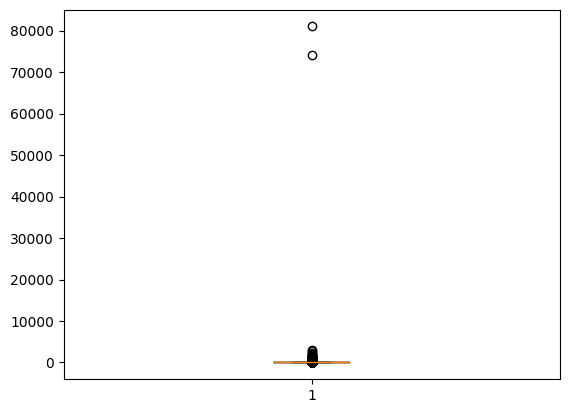

In [17]:
# Conferir os dados de quantidade pois parece ter alguns valores extremos

quantity_values = ecommerce_clean['quantity']

plt.boxplot(quantity_values)
plt.show()

In [18]:
# Filtrar os dados para remover dados de 'quantity' acima de 10000

ecommerce_clean = ecommerce_clean[ecommerce_clean['quantity']<=10000]

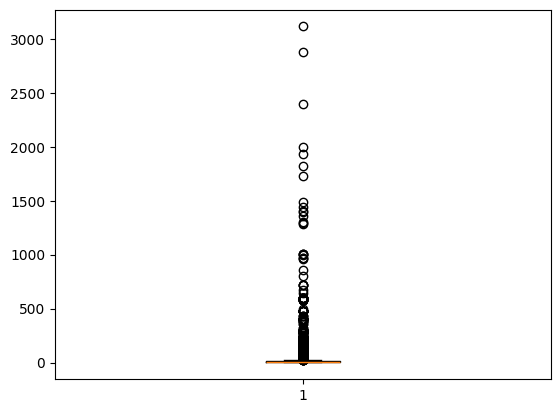

In [19]:
# Conferir os dados de quantidade após remoção

quantity_values_2 = ecommerce_clean['quantity']

plt.boxplot(quantity_values_2)
plt.show()

In [20]:
''' Acredito que tenha algo de errado com esses dados com valores acima de 1000 itens do mesmo pedido
    Estou pensando em agrupar por usuário e pedido e ver o máximo de produtos pedidos'''

group_user_orders = ecommerce_clean.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_user_orders.head(20))

customer_id  description                         unit_price
15749        FAIRY CAKE FLANNEL ASSORTED COLOUR  2.10          3114
16754        WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.18          2880
16029        GROW A FLYTRAP OR SUNFLOWER IN TIN  0.94          2400
15749        GIN + TONIC DIET METAL SIGN         1.85          2000
             WHITE HANGING HEART T-LIGHT HOLDER  2.55          1930
15299        ASSORTED COLOUR T-LIGHT HOLDER      0.55          1824
12875        ASSORTED LAQUERED INCENSE HOLDERS   0.17          1728
12755        ROUND SNACK BOXES SET OF 4 FRUITS   2.55          1488
14156        ASSORTED INCENSE PACK               0.16          1440
16754        RED HARMONICA IN BOX                1.06          1400
17857        MINI PAINT SET VINTAGE              0.55          1394
17450        HEART OF WICKER SMALL               1.93          1356
15749        TEA TIME TEA TOWELS                 2.55          1300
17306        PACK OF 12 LONDON TISSUES           0.25   

- Com essa informação vejo que alguns dados os pedidos provavelmente estão errados, sendo assim vou filtrar o dataframe para quantidade superior e inferior a 300 pedidos e ver o resultado nos dados

In [21]:
# Filtrando as quantidades com limite de 300

above_300 = ecommerce_clean[ecommerce_clean['quantity'] >= 300]
below_300 = ecommerce_clean[ecommerce_clean['quantity'] < 300]

In [22]:
above_300.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 479 to 40054
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    89 non-null     object        
 1   stock_code    89 non-null     object        
 2   description   89 non-null     object        
 3   quantity      89 non-null     int64         
 4   invoice_date  89 non-null     datetime64[ns]
 5   unit_price    89 non-null     float64       
 6   customer_id   89 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 5.2+ KB


In [23]:
below_300.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39440 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    39440 non-null  object        
 1   stock_code    39440 non-null  object        
 2   description   39440 non-null  object        
 3   quantity      39440 non-null  int64         
 4   invoice_date  39440 non-null  datetime64[ns]
 5   unit_price    39440 non-null  float64       
 6   customer_id   39440 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.3+ MB


In [24]:
# Conferir a lista com os valores máximos até 300 pedidos

group_below_300 = below_300.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_below_300.head(20))

customer_id  description                         unit_price
15311        DECORATIVE CATS BATHROOM BOTTLE     0.42          288
17511        DISCO BALL CHRISTMAS DECORATION     0.10          288
18092        MOROCCAN TEA GLASS                  0.65          288
14646        5 HOOK HANGER RED MAGIC TOADSTOOL   1.45          288
17404        TEA BAG PLATE RED RETROSPOT         0.85          288
16422        SET/10 RED POLKADOT PARTY CANDLES   1.06          288
14156        SET/5 RED SPOTTY LID GLASS BOWLS    2.55          288
17511        FELT FARM ANIMAL WHITE BUNNY        0.19          288
14646        ASSORTED EASTER DECORATIONS BELLS   1.06          288
             PLASTERS IN TIN WOODLAND ANIMALS    1.45          288
16191        HAND WARMER BABUSHKA DESIGN         0.85          288
16210        POTTERING MUG                       0.42          288
16684        FANCY FONT BIRTHDAY CARD            0.36          288
14646        SET/10 BLUE POLKADOT PARTY CANDLES  1.06          288
16

- Olhando os produtos posso dizer que mesmo filtrando os pedidos com quantidade inferior a 300, ainda temos produtos com valores que não aparentam ser adequados para esses tipos de produtos.
- É necessário realizar novo tratamento desses dados e aplicar outra filtragem, nesse caso trabalharei com 100 itens

In [25]:
# Filtrando as quantidades com limite de 100

above_100 = ecommerce_clean[ecommerce_clean['quantity'] >= 100]
below_100 = ecommerce_clean[ecommerce_clean['quantity'] < 100]

In [26]:
above_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 45 to 40644
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    621 non-null    object        
 1   stock_code    621 non-null    object        
 2   description   621 non-null    object        
 3   quantity      621 non-null    int64         
 4   invoice_date  621 non-null    datetime64[ns]
 5   unit_price    621 non-null    float64       
 6   customer_id   621 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 36.4+ KB


In [27]:
below_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38908 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    38908 non-null  object        
 1   stock_code    38908 non-null  object        
 2   description   38908 non-null  object        
 3   quantity      38908 non-null  int64         
 4   invoice_date  38908 non-null  datetime64[ns]
 5   unit_price    38908 non-null  float64       
 6   customer_id   38908 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.2+ MB


In [28]:
# Conferir a lista com os valores máximos até 100 pedidos

group_below_100 = below_100.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_below_100.head(20))

customer_id  description                          unit_price
12415        PINK POLKADOT PLATE                  1.45          96
12370        HEART DECORATION PAINTED ZINC        0.65          96
14646        PLASTERS IN TIN VINTAGE PAISLEY      1.45          96
13089        HEART IVORY TRELLIS SMALL            1.25          96
14646        PLASTERS IN TIN STRONGMAN            1.45          96
14258        SET/6 RED SPOTTY PAPER PLATES        0.64          96
14646        BLUE POLKADOT CUP                    0.72          96
14258        SET/20 RED RETROSPOT PAPER NAPKINS   0.64          96
15061        MAGIC DRAWING SLATE SPACEBOY         0.36          96
17511        6 RIBBONS SHIMMERING PINKS           0.42          96
14062        HAND WARMER BABUSHKA DESIGN          0.85          96
17511        BAG 125g SWIRLY MARBLES              0.36          96
15330        FEATHER PEN LIGHT PINK               0.39          96
14646        BLUE STRIPE CERAMIC DRAWER KNOB      1.06          96
1

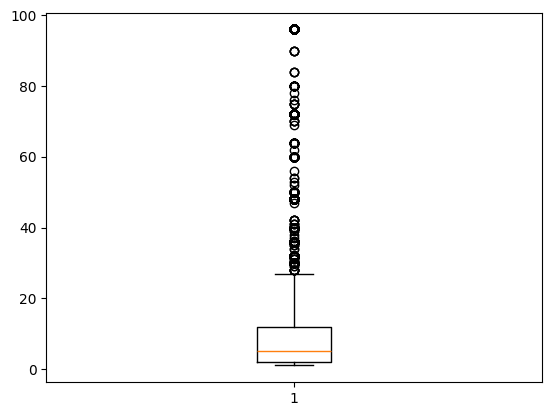

In [29]:
# Plotar histograma de quantidade inferior a 100

quant_below_100 = below_100['quantity']

plt.boxplot(quant_below_100)
plt.show()

- Com base neste novo boxplot é possível ver a distribuição dos dados onde temos o limite superior próximo a 20.
    - O passo agora é calcular esse limite, realizar nova filtragem dos dados e observar se vale a pena manter a nova filtragem ou utilizar os dados com quantidade abaixo de 100

In [30]:
''' Observação para mim mesmo, eu poderia ter realizado isso logo após confeccionar o primeiro boxplot ao invés de ficar adivinhando valores'''

# Calcular o limite superior do boxplot

# Calcular o terceiro quartil
q3 = below_100['quantity'].quantile(0.75)

# Calcular o primeiro quartil
q1 = below_100['quantity'].quantile(0.25)

# Calcular o intervalo interquartil (IQR)
iqr = q3-q1

# Calcular o limite superior
upper_limit = q3 + 1.5 * iqr

print("O limite superior é: ", upper_limit)

O limite superior é:  27.0


- Como descobri que o limite superior é de 27, vou realizar a filtragem dos dados para 'quantity' até 27 e depois estudar os dados

In [31]:
# Filtrando os dados para quantity até 27
below_27 = ecommerce_clean[ecommerce_clean['quantity'] <= 27]

In [32]:
below_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36844 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    36844 non-null  object        
 1   stock_code    36844 non-null  object        
 2   description   36844 non-null  object        
 3   quantity      36844 non-null  int64         
 4   invoice_date  36844 non-null  datetime64[ns]
 5   unit_price    36844 non-null  float64       
 6   customer_id   36844 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.1+ MB


In [33]:
# Conferindo o total de usuários únicos após a filtragem

unique_users_27 = below_27['customer_id'].nunique()

print(unique_users_27)

1680


- Com base nos resultados obtidos temos 1680 usuários únicos no novo dataframe filtrado

### 1.4 Estudando a coluna 'unit_price'

- Antes de mais nada, vou criar renomear o dataframe 'below_27' para 'ecommerce_clean_27' assim entendo de onde vieram esses dados já que eles foram limpos uma vez e filtrados.

In [34]:
# Renomeando o Dataframe para trabalho

ecommerce_clean_27 = below_27

In [35]:
# Conferir a lista com os valores máximos até 100 pedidos

group_unit_price = ecommerce_clean_27.groupby(['description','quantity'])['unit_price'].max().sort_values(ascending=False)
print(group_unit_price.head(20))

description                        quantity
VINTAGE RED KITCHEN CABINET        1           295.00
LOVE SEAT ANTIQUE WHITE METAL      2           175.00
RUSTIC SEVENTEEN DRAWER SIDEBOARD  1           165.00
REGENCY MIRROR WITH SHUTTERS       1           165.00
CARRIAGE                           1           150.00
RUSTIC SEVENTEEN DRAWER SIDEBOARD  2           145.00
CHEST NATURAL WOOD 20 DRAWERS      1           125.00
VINTAGE RED KITCHEN CABINET        2           125.00
VINTAGE BLUE KITCHEN CABINET       1           125.00
                                   2           125.00
CHEST NATURAL WOOD 20 DRAWERS      4           110.00
VINTAGE POST OFFICE CABINET        1            79.95
SCHOOL DESK AND CHAIR              1            65.00
                                   2            65.00
VINTAGE POST OFFICE CABINET        10           52.77
HALL CABINET WITH 3 DRAWERS        1            49.95
PINK PAINTED KASHMIRI CHAIR        4            42.95
POSTAGE                            2  

- Observando os preços dos itens, os mesmos parecem de acordo com os itens em questão.

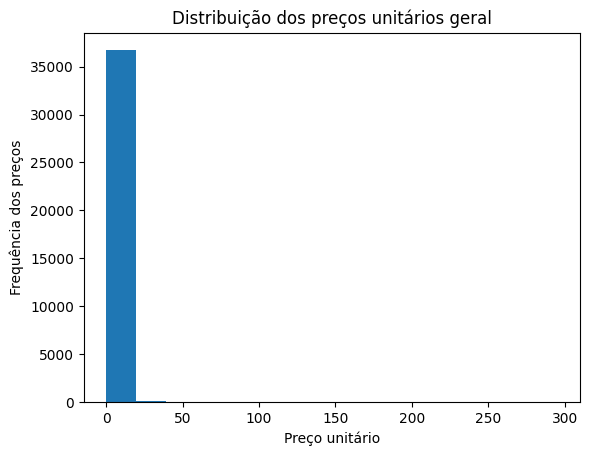

In [36]:
# Histograma da distribuição dos preços
plt.hist(ecommerce_clean_27['unit_price'], bins=15)
plt.ylabel('Frequência dos preços')
plt.xlabel('Preço unitário')
plt.title('Distribuição dos preços unitários geral')
plt.show()

- O histograma nos mostra que a grande maioria dos preços unitários dos produtos se encontra entre zero e 25.

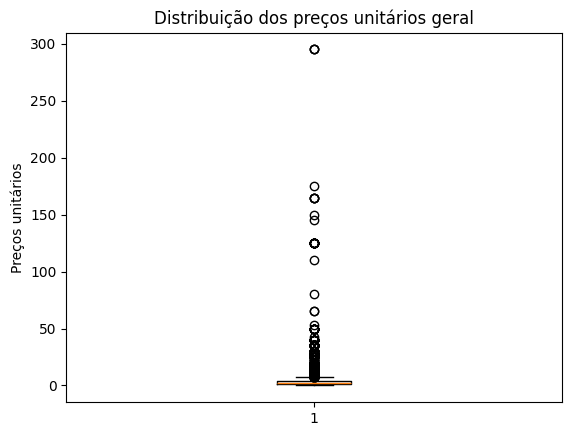

In [37]:
# Boxplot da distribuição dos preços
plt.boxplot(ecommerce_clean_27['unit_price'])
plt.ylabel('Preços unitários')
plt.title('Distribuição dos preços unitários geral')
plt.show()

- Com o boxplot dos preços unitarios podemos ver que há vários produtos com valores outliers justificados pelo tipo de produto em si.

In [38]:
# Calcular o limite superior do boxplot

# Calcular o terceiro quartil
q3 = ecommerce_clean_27['unit_price'].quantile(0.75)

# Calcular o primeiro quartil
q1 = ecommerce_clean_27['unit_price'].quantile(0.25)

# Calcular o intervalo interquartil (IQR)
iqr = q3-q1

# Calcular o limite superior
upper_limit = q3 + 1.5 * iqr

print("O limite superior de preço é: ", upper_limit)

O limite superior de preço é:  7.5


- Pelo boxplot podemos observar que o limite superior de preço unitario é 7,5 e como a loja vende produtos muito mais caros, mas que saem com menos frequência, isso justifica os outliers.

### 1.5 Resumo dos dados


In [39]:
#Criar uma tabela para resumir os dados
pd.DataFrame([{'products': len(ecommerce_clean_27['stock_code'].value_counts()),
               'transactions':len(ecommerce_clean_27['invoice_no'].value_counts()),
               'customers':len(ecommerce_clean_27['customer_id'].value_counts()),
               }], columns=['products','transactions','customers'], index=['quantity'])

,products,transactions,customers
quantity,2543,3438,1680


- Após todo o tratamento dos dados podemos ver que os resultados advém de 1680 usuários, os quais compraram 2543 produtos diferentes sendo que o total de transações realizadas foi de 3438.

### 1.6 Ordens canceladas

In [40]:
# Determinar o número de produtos por carrinho
temp = ecommerce_clean_27.groupby(by=['customer_id','invoice_no'], as_index=False)['invoice_date'].count()
nb_products_per_basket = temp.rename(columns={'invoice_date':'number_of_products'})
print(nb_products_per_basket[:10].sort_values('customer_id'))

   customer_id invoice_no  number_of_products
0        12347     537626                  29
1        12347     556201                   1
2        12348     539318                   5
3        12356     541430                  22
4        12357     574740                   5
5        12359     540946                  16
6        12360     563749                   1
7        12364     573401                   1
8        12370     538826                  77
9        12370     539330                   8


In [41]:
# Determinar o número de ordens canceladas
nb_products_per_basket['order_canceled'] = nb_products_per_basket['invoice_no'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

# Contabilizar o número de canceladas

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Número de ordens canceladas: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,customer_id,invoice_no,number_of_products,order_canceled
0,12347,537626,29,0
1,12347,556201,1,0
2,12348,539318,5,0
3,12356,541430,22,0
4,12357,574740,5,0


Número de ordens canceladas: 0/3438 (0.00%) 


- Nesse caso posso observar que não há ordens canceladas dentro do conjunto de dados.

### 1.7 - Total gasto por ordem

#### 1.7.1 - Criando coluna com total gasto

In [42]:
ecommerce_clean_27['total_spent'] = (ecommerce_clean_27['unit_price'] * ecommerce_clean_27['quantity'])

C:\Users\renan\AppData\Local\Temp\ipykernel_4032\3784831467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27['total_spent'] = (ecommerce_clean_27['unit_price'] * ecommerce_clean_27['quantity'])


#### 1.7.2 Conferindo se todos os valores são numéricos

In [43]:
#Imprimindo para ver se todos os valores da coluna total_spent são numéricos
try:
    pd.to_numeric(ecommerce_clean_27['total_spent'])
    print("A coluna 'total_spent' contém apenas números.")
except ValueError:
    print("A coluna 'total_spent' contém valores não numéricos.")

A coluna 'total_spent' contém apenas números.


In [44]:
# Criar tabela temporaria
temp = ecommerce_clean_27.groupby(by=['customer_id','invoice_no'], as_index=False)['total_spent'].sum()
basket_total = temp.rename(columns={'total_spent':'basket_total'})

# Data da compra
ecommerce_clean_27['date_int'] = ecommerce_clean_27['invoice_date'].astype('int64')
temp = ecommerce_clean_27.groupby(by=['customer_id','invoice_no'], as_index=False)['date_int'].mean()
ecommerce_clean_27.drop('date_int', axis=1, inplace=True)
basket_total.loc[:, 'invoice_date'] = pd.to_datetime (temp['date_int'])

# Mostrar os valores 
basket_total = basket_total[basket_total['basket_total'] > 0]
print(basket_total.sort_values('customer_id')[:6])

   customer_id invoice_no  basket_total        invoice_date
0        12347     537626        650.89 2018-12-05 14:57:00
1        12347     556201         10.20 2019-06-07 13:01:00
2        12348     539318        292.80 2018-12-14 19:09:00
3        12356     541430       1565.58 2019-01-16 09:50:00
4        12357     574740        106.56 2019-11-04 16:07:00
5        12359     540946        547.50 2019-01-10 12:43:00


C:\Users\renan\AppData\Local\Temp\ipykernel_4032\1921197234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27['date_int'] = ecommerce_clean_27['invoice_date'].astype('int64')
C:\Users\renan\AppData\Local\Temp\ipykernel_4032\1921197234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27.drop('date_int', axis=1, inplace=True)


- Com base nessa segmentação consigo separar o total dos carrinhos por faixas

In [45]:
# Separar a distribuição das compras

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_total[(basket_total['basket_total'] < price) &
                       (basket_total['basket_total'] > price_range[i-1])]['basket_total'].count()
    count_price.append(val)

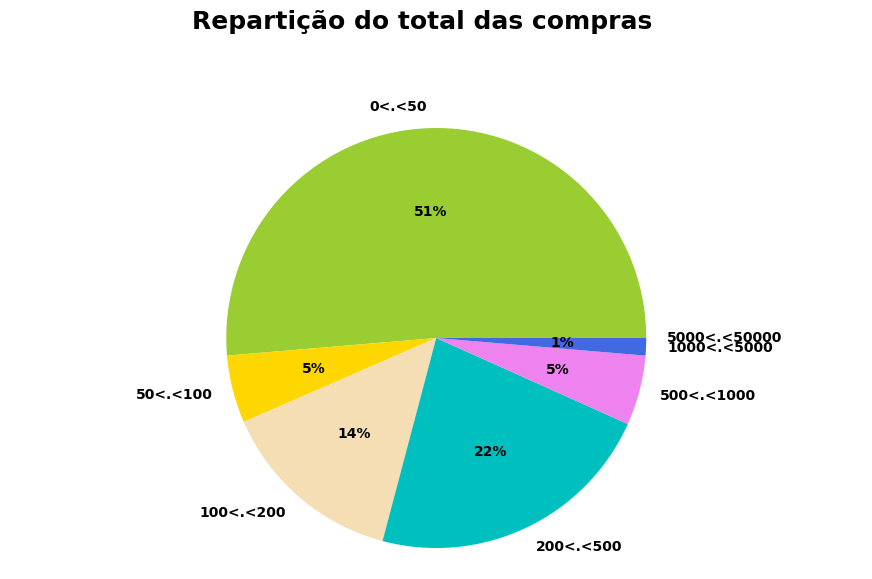

In [46]:
# Plotar a distribuição das compras

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Repartição do total das compras", ha='center', fontsize = 18);

- Com base nos resultados obtidos temos que a maioria das compras (por número do pedido) se encontram entre 0 e 50, representando 51% do total, seguido de carrinhos com valor indo de 200 a 500 o qual representa 22% das ordens.

### 1.8 Códigos em stock_code

In [47]:
# Obtendo códigos especiais presentes nas células de stock_code
list_special_codes = ecommerce_clean_27[ecommerce_clean_27['stock_code'].str.contains('^[a-zA-Z]+', regex=True)]['stock_code'].unique()
print(list_special_codes)

['POST' 'C2' 'M' 'BANK CHARGES']


In [48]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, ecommerce_clean_27[ecommerce_clean_27['stock_code'] == code]['description'].unique()[0]))

POST            -> POSTAGE                       
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  


- Podemos ver que existem casos com transações diferentes no dataframe

## 2 Adição de dados

### 2.1 Adicionar coluna de data, ano, mês e dia no dataframe com base em invoice_date

In [49]:
ecommerce_clean_27['date'] = ecommerce_clean_27['invoice_date'].dt.date

C:\Users\renan\AppData\Local\Temp\ipykernel_4032\1964287090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27['date'] = ecommerce_clean_27['invoice_date'].dt.date


In [50]:
# Obtendo os resultados pós adição da coluna 'date'
print(ecommerce_clean_27.head())

  invoice_no stock_code                     description  quantity  \
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   
5     537626      22727       ALARM CLOCK BAKELIKE RED          4   
6     537626      22728       ALARM CLOCK BAKELIKE PINK         4   

         invoice_date  unit_price  customer_id  total_spent        date  
2 2018-12-05 14:57:00        4.95        12347        14.85  2018-12-05  
3 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  
4 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  
5 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  
6 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  


In [51]:
ecommerce_clean_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36844 entries, 2 to 41230
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    36844 non-null  object        
 1   stock_code    36844 non-null  object        
 2   description   36844 non-null  object        
 3   quantity      36844 non-null  int64         
 4   invoice_date  36844 non-null  datetime64[ns]
 5   unit_price    36844 non-null  float64       
 6   customer_id   36844 non-null  int32         
 7   total_spent   36844 non-null  float64       
 8   date          36844 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 2.7+ MB


- Deu certo a inserção de novas colunas no Dataframe

## 3 Análise de Coorte

#### 3.1 Retorno por usuário

In [52]:
#Copiar os dados formatados para outro dataframe para trabalhar
coorte_data = ecommerce_clean_27.copy()

In [53]:
# Agrupando os dados por cliente e data da compra e separando o valor mínimo
first_order_date_by_customers = coorte_data.groupby('customer_id')['invoice_date'].min()

In [54]:
# Renomeando a coluna
first_order_date_by_customers.name = 'first_order_date'

In [55]:
# Unindo os dados de data mínima para cada usuário
coorte_data = coorte_data.join(first_order_date_by_customers, on='customer_id')

In [56]:
#Separando o mês do primeiro pedido
coorte_data['first_order_month'] = pd.to_datetime(coorte_data['first_order_date'], format='%Y-%m-%d').dt.to_period('M')

In [57]:
#separando o mês do pedido
coorte_data['order_month'] = pd.to_datetime(coorte_data['invoice_date'], format='%Y-%m-%d').dt.to_period('M')

In [58]:
#Agrupar os valores de total gasto e usuarios unicos para o primeiro mês do pedido e o mês
orders_grouped_by_cohorts = coorte_data.groupby(['first_order_month', 'order_month']).agg({'total_spent': 'sum', 'customer_id': 'nunique'})

In [59]:
#Calcular o retorno por usuário
orders_grouped_by_cohorts['revenue_per_user'] = (orders_grouped_by_cohorts['total_spent']/ orders_grouped_by_cohorts['customer_id'])

In [60]:
#Criar a tabela pivotante com base nos periodos de cada coorte
value_spent = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='revenue_per_user',
    aggfunc='mean',
)

print(value_spent)

order_month           2018-11     2018-12     2019-01    2019-02    2019-03  \
first_order_month                                                             
2018-11            300.513621  577.375937  437.268333  15.708571  16.772353   
2018-12                   NaN  395.600940  383.925301  18.461818  17.804130   
2019-01                   NaN         NaN  293.429120  23.503333  13.381818   
2019-02                   NaN         NaN         NaN  20.600000  24.000000   
2019-03                   NaN         NaN         NaN        NaN  15.144205   
2019-04                   NaN         NaN         NaN        NaN        NaN   
2019-05                   NaN         NaN         NaN        NaN        NaN   
2019-06                   NaN         NaN         NaN        NaN        NaN   
2019-07                   NaN         NaN         NaN        NaN        NaN   
2019-08                   NaN         NaN         NaN        NaN        NaN   
2019-09                   NaN         NaN         Na

Text(0.5, 69.7222222222222, 'Mês da compra')

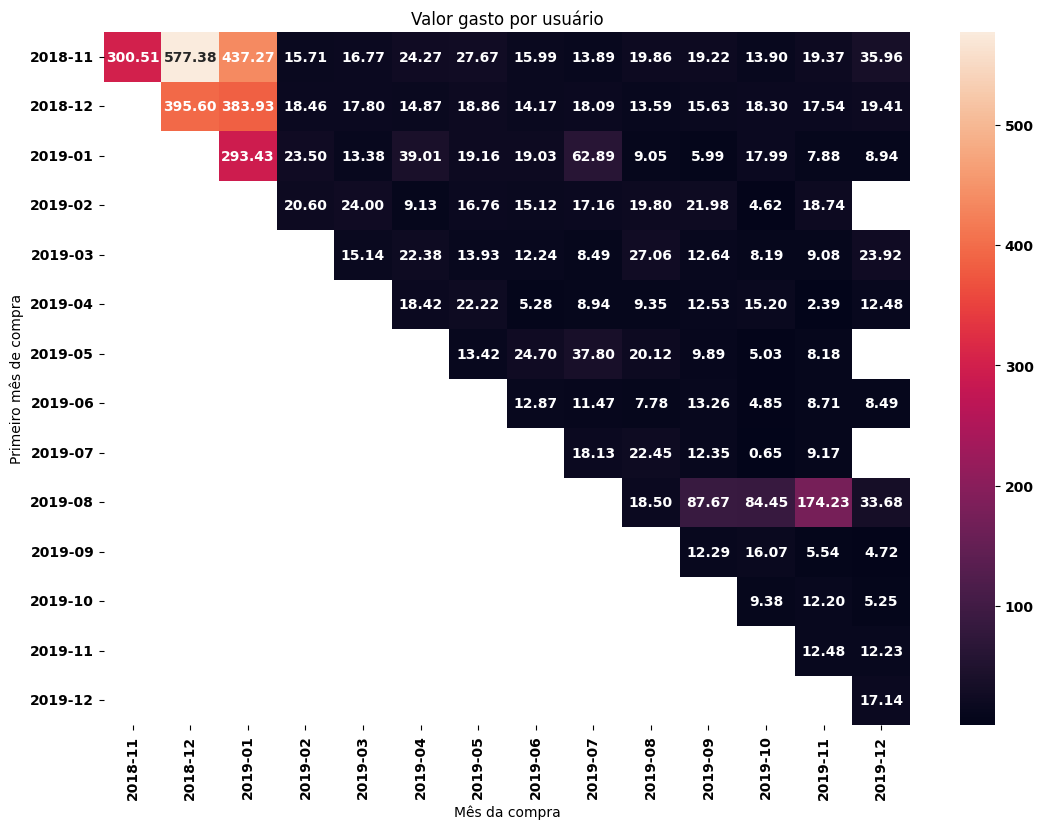

In [61]:
# Plotando um mapa de calor

plt.figure(figsize=(13,9))
plt.title('Valor gasto por usuário')
sns.heatmap(value_spent,
            annot=True,
            fmt='.2f',
            linecolor='black',)
plt.ylabel("Primeiro mês de compra")
plt.xlabel("Mês da compra")

- Conclusão
    - Com base nos dados obtidos podemos ver que para a maioria das coortes há uma redução nos gastos por usuário com o passar do tempo.

## 4 Segmentação

### 4.1 RFM (reincidence, frequency, monetary)

In [62]:
rfm_dataframe = ecommerce_clean_27.copy()

In [63]:
rfm_dataframe.describe()

,quantity,invoice_date,unit_price,customer_id,total_spent
count,36844.000000,36844,36844.000000,36844.000000,36844.000000
mean,6.917490,2018-12-31 10:57:37.347736064,3.171272,15405.471909,14.526461
min,1.000000,2018-11-29 08:26:00,0.000000,12347.000000,0.000000
25%,2.000000,2018-12-05 11:59:00,1.250000,14032.000000,4.200000
50%,4.000000,2018-12-12 14:42:00,2.100000,15384.000000,10.200000
75%,12.000000,2019-01-05 16:32:00,3.750000,17019.000000,17.700000
max,27.000000,2019-12-07 12:16:00,295.000000,18283.000000,559.200000
std,6.762105,NaN,5.388481,1763.404482,19.117818


In [64]:
# Obtendo os valores de menor e maior data da dimensão de dados

menor_data, maior_data = rfm_dataframe['invoice_date'].min(), rfm_dataframe['invoice_date'].max()
maior_data = maior_data + pd.DateOffset(days=1) #Adicionado um dia a maior compra para iniciar a analise

In [65]:
# Obtendo as dez maiores vendas
rfm_dataframe.groupby('invoice_date')[['total_spent']].sum().sort_values('total_spent', ascending=False)[:10]

,total_spent
invoice_date,
2019-01-04 16:41:00,3164.10
2019-01-05 12:28:00,2140.11
2018-12-08 15:45:00,1904.88
2018-12-12 12:59:00,1883.12
2018-12-06 15:56:00,1826.51
2018-12-07 12:17:00,1764.15
2019-01-08 09:11:00,1715.85
2018-12-11 15:44:00,1669.52
2018-12-01 14:04:00,1648.29


In [66]:
# Descobrir quais os produtos mais vendidos

print('Produtos mais vendidos (quantidade)', '\n', 60 *'-')
print(rfm_dataframe.groupby('description')[['quantity','total_spent']].sum().sort_values('quantity',ascending=False)[:10])
print()
print(60 * '*')
print('Produtos mais vendidos (valor)', '\n', 60 *'-')
print(rfm_dataframe.groupby('description')[['quantity','total_spent']].sum().sort_values('total_spent',ascending=False)[:10])

Produtos mais vendidos (quantidade) 
 ------------------------------------------------------------
                                    quantity  total_spent
description                                              
FANCY FONT BIRTHDAY CARD                3240      1360.80
FEATHER PEN HOT PINK                    2054      1027.32
KEY FOB SHED                            1977      1316.41
ELEPHANT BIRTHDAY CARD                  1562       656.04
WHITE HANGING HEART T-LIGHT HOLDER      1559      4555.05
KEY FOB BACK DOOR                       1550      1021.22
JAM MAKING SET PRINTED                  1524      2209.80
BIRTHDAY CARD RETRO SPOT                1452       609.84
FEATHER PEN COAL BLACK                  1406       735.30
HAND WARMER BABUSHKA DESIGN             1398      2095.80

************************************************************
Produtos mais vendidos (valor) 
 ------------------------------------------------------------
                                    quantity  tot

- Temos agora o top 10 produtos mais vendidos em quantidade e o top 10 produtos mais vendidos por valor financeiro gerado

In [67]:
# Dividir os valores em quatro períodos de análise

periodoA, periodoB, periodoC, periodoD = pd.date_range(menor_data, maior_data, periods=4)

In [68]:
rfm_table = rfm_dataframe.groupby('customer_id').agg({'invoice_date': lambda date: (maior_data - date.max()).days,
                                                      'invoice_no': lambda num: len(num),
                                                      'total_spent': lambda valor: valor.sum()})

# Renomear as colunas para condizer com a análise RFM
rfm_table.columns = ['recency','frequency','monetary']
display(rfm_table.head(10).sort_values('monetary', ascending=False))


,recency,frequency,monetary
customer_id,,,
12356,326,22,1565.58
12370,51,87,1550.77
12377,355,43,1001.52
12347,183,30,661.09
12359,331,16,547.50
12348,358,5,292.80
12357,33,5,106.56
12378,130,1,51.00
12360,113,1,5.04


- Essa tabela nos mostra que o consumidor que mais gastou trouxe um retorno de 1565,58, com uma baixa frequência em comparação ao anterior porém faz tempo que não realiza alguma compra pois a recencia está em 326 dias.

In [69]:
# Renomear as colunas para condizer com a análise RFM
rfm_table.columns = ['recency','frequency','monetary']

# Visualizar o resultado
display(rfm_table.head(10).sort_values('frequency', ascending=False))

,recency,frequency,monetary
customer_id,,,
12370,51,87,1550.77
12377,355,43,1001.52
12347,183,30,661.09
12356,326,22,1565.58
12359,331,16,547.50
12348,358,5,292.80
12357,33,5,106.56
12360,113,1,5.04
12364,40,1,5.04


- Esta tabela nos traz que alguns clientes apresentam maior frequência de compras no site.

In [70]:
# Ordenar conforme 'recency'

rfm_table.columns = ['recency','frequency','monetary']
# Visualizar o resultado
display(rfm_table.head(10).sort_values('recency', ascending=False))

,recency,frequency,monetary
customer_id,,,
12348,358,5,292.80
12377,355,43,1001.52
12359,331,16,547.50
12356,326,22,1565.58
12347,183,30,661.09
12378,130,1,51.00
12360,113,1,5.04
12370,51,87,1550.77
12364,40,1,5.04


- Esta tabela nos traz que temos alguns consumidores que não realizam compras a mais de 300 dias.

In [71]:
# Classificando os dados de acordo com quartis 
rfm_table['recency_quartile'] = pd.qcut(rfm_table['recency'], 4, ['1','2','3','4']) # mais recente, mais importante
rfm_table['frequency_quartile'] = pd.qcut(rfm_table['frequency'], 4, ['4','3','2','1']) # menos frequencia, menos importante
rfm_table['monetary_quartile'] = pd.qcut(rfm_table['monetary'], 4, ['4','3','2','1']) # menos consumo, manos importante

In [72]:
# Exibindo o resultado
print(rfm_table.head())

             recency  frequency  monetary recency_quartile frequency_quartile  \
customer_id                                                                     
12347            183         30    661.09                2                  1   
12348            358          5    292.80                4                  3   
12356            326         22   1565.58                3                  2   
12357             33          5    106.56                1                  3   
12359            331         16    547.50                3                  2   

            monetary_quartile  
customer_id                    
12347                       1  
12348                       2  
12356                       1  
12357                       3  
12359                       1  


In [73]:
# Obtendo o score de cada usuário baseand-se na recencia e frequência
rfm_table['rfm_score'] = rfm_table.recency_quartile.astype(str) + rfm_table.frequency_quartile.astype(str)
rfm_table.head().sort_values('rfm_score', ascending=False)

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile,rfm_score
customer_id,,,,,,,
12348,358,5,292.80,4,3,2,43
12356,326,22,1565.58,3,2,1,32
12359,331,16,547.50,3,2,1,32
12347,183,30,661.09,2,1,1,21
12357,33,5,106.56,1,3,3,13


- Com o auxilio do score podemos separar quais os clientes possuem uma maior nota RFM e possivelmente enviar promoções para o mesmo.
    - Essa estratégia também serve para clientes com baixa nota, o que pode ser enviado para eles que estimule sua compra no site?

- Ainda, com base nos rfm_score é possível então segmentar os clientes em grupos: alto, médio e baixo.

In [74]:
# Criar segmentação de clientes
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_lose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_table['segment'] = rfm_table['rfm_score'].astype(str).replace(seg_map, regex=True)

print(rfm_table.head().sort_values('rfm_score', ascending=False))


             recency  frequency  monetary recency_quartile frequency_quartile  \
customer_id                                                                     
12348            358          5    292.80                4                  3   
12356            326         22   1565.58                3                  2   
12359            331         16    547.50                3                  2   
12347            183         30    661.09                2                  1   
12357             33          5    106.56                1                  3   

            monetary_quartile rfm_score              segment  
customer_id                                                   
12348                       2        43  potential_loyalists  
12356                       1        32       about_to_sleep  
12359                       1        32       about_to_sleep  
12347                       1        21          hibernating  
12357                       3        13              a

In [75]:
'''
Champions — compraram recentemente, compram com frequência e gastam mais.
Loyal Customers — gastam um bom dinheiro e respondem bem às promoções.
Potential Loyalists — clientes recentes, que gastaram uma boa quantia e compraram mais de uma vez.
New Customers — compraram recentemente, mas não com frequência.
Promissing — compradores recentes, mas que não gastaram muito.
Need Attention — recência, frequência e valores monetários acima da média; mas podem não ter comprado muito recentemente.
About To Sleep — recência, frequência e valores monetários abaixo da média; serão perdidos se não forem reativados.
At Risk — gastaram muito dinheiro e compraram com frequência, mas há muito tempo; é preciso trazê-los de volta.
Can’t Lose Them — fizeram compras grandes e muitas vezes, mas não voltam a realizar transações há muito tempo.
Hibernating — a última compra foi há muito tempo, pouco gastadores e baixo número de pedidos.'''

'\nChampions — compraram recentemente, compram com frequência e gastam mais.\nLoyal Customers — gastam um bom dinheiro e respondem bem às promoções.\nPotential Loyalists — clientes recentes, que gastaram uma boa quantia e compraram mais de uma vez.\nNew Customers — compraram recentemente, mas não com frequência.\nPromissing — compradores recentes, mas que não gastaram muito.\nNeed Attention — recência, frequência e valores monetários acima da média; mas podem não ter comprado muito recentemente.\nAbout To Sleep — recência, frequência e valores monetários abaixo da média; serão perdidos se não forem reativados.\nAt Risk — gastaram muito dinheiro e compraram com frequência, mas há muito tempo; é preciso trazê-los de volta.\nCan’t Lose Them — fizeram compras grandes e muitas vezes, mas não voltam a realizar transações há muito tempo.\nHibernating — a última compra foi há muito tempo, pouco gastadores e baixo número de pedidos.'

In [76]:
print(rfm_table.columns)

Index(['recency', 'frequency', 'monetary', 'recency_quartile',
       'frequency_quartile', 'monetary_quartile', 'rfm_score', 'segment'],
      dtype='object')


Text(0.5, 1.0, 'Número total de usuários por segmento')

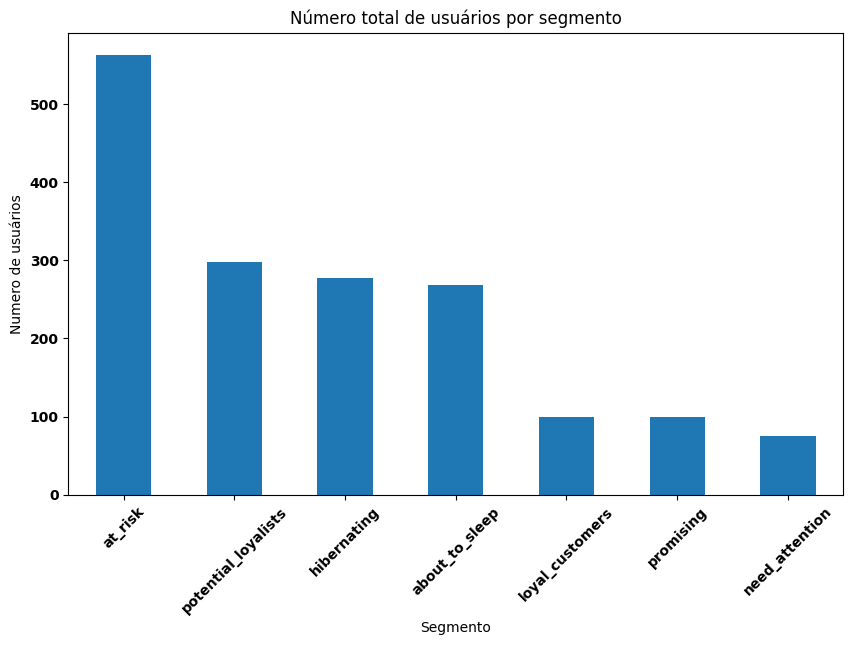

In [77]:
# Criar um gráfico de barras para a distribuição do total de usuários dentro de cada segmento

segment_users = rfm_table['segment'].value_counts()

# Plotando os dados
plt.figure(figsize=[10,6])
segment_users.plot(kind='bar')
plt.ylabel('Numero de usuários')
plt.xlabel('Segmento')
plt.xticks(rotation=45)
plt.title("Número total de usuários por segmento")

In [78]:
print(segment_users)

segment
at_risk                563
potential_loyalists    298
hibernating            277
about_to_sleep         268
loyal_customers        100
promising               99
need_attention          75
Name: count, dtype: int64


- Conclusão 
    - Com base no gráfico de barras podemos observar que a maioria dos clientes se encontra no segmento de risco (at_risk). Clientes potenciais fieis (potential_loyalists) estão em segundo lugar e clientes em estado de hibernação (hibernating) e próximo a hibernar (about_to_sleep) também fazem parte dos clientes com mais representatividade.
   

### 4.2 Por produtos

#### 4.2.1 Separar as palavras chave na descrção dos produtos.

In [79]:
# Copiar os dados alterados para usar na separação por produtos

per_product_df = ecommerce_clean_27.copy()

- Pode ser realizada a segmentação por nome dos produtos para posterior agrupamento dos dados

In [80]:
# Extrair a variável da descrição

is_noun = lambda pos: pos[:2] == 'NN'

# Criando a função

def keywords_inventory(dataframe, colonne = 'description'):
    stemmer = nltk.stem.SnowballStemmer("english") # entende que as palavras estão em inglês
    keywords_roots = dict() #coleta as palavras
    keywords_select = dict() #associa raiz a palavra
    category_keys = []
    count_keywords = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word,pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s])> 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    print("Num de palavras chave na variavel '{}' : {}".format(colonne,len(category_keys)))
    return category_keys,keywords_roots, keywords_select, count_keywords


- Em resumo, essa função:
    - Extrai os nomes que aparecem na descrição dos produtos
    - Para cada nome extrai a raiz da palavra e agrega o conjunto de nomes associados a essa palavra em particular
    - conta o número de vezes que cada 'raiz' aparece no dataframe
    - quando várias palavras são listadas para a mesma raiz, considera que a álavra associada a essa raiz é o menor nome

In [81]:
# Retornar a lista de produtos

df_products = pd.DataFrame(per_product_df['description'].unique()).rename(columns={0:'description'})

In [82]:
# Após criar a lista uso a função para analizar a descrição dos vários produtos
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Num de palavras chave na variavel 'description' : 1176


In [83]:
'''
Isso resulta em três variáveis:
    keywords: a lista das palavras chave extraidas
    keywords_roots: um dicionário onde as chaves são as palavras chaves e os valores a lista de palavras associadas a essas raizes
    count_keywords: um dicionario listando o número de vezes que cada palavra é usada
'''

'\nIsso resulta em três variáveis:\n    keywords: a lista das palavras chave extraidas\n    keywords_roots: um dicionário onde as chaves são as palavras chaves e os valores a lista de palavras associadas a essas raizes\n    count_keywords: um dicionario listando o número de vezes que cada palavra é usada\n'

In [84]:
# Transformar count_keywords em uma lista para distribui-las conforme a frequência

list_products = []
for k, v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

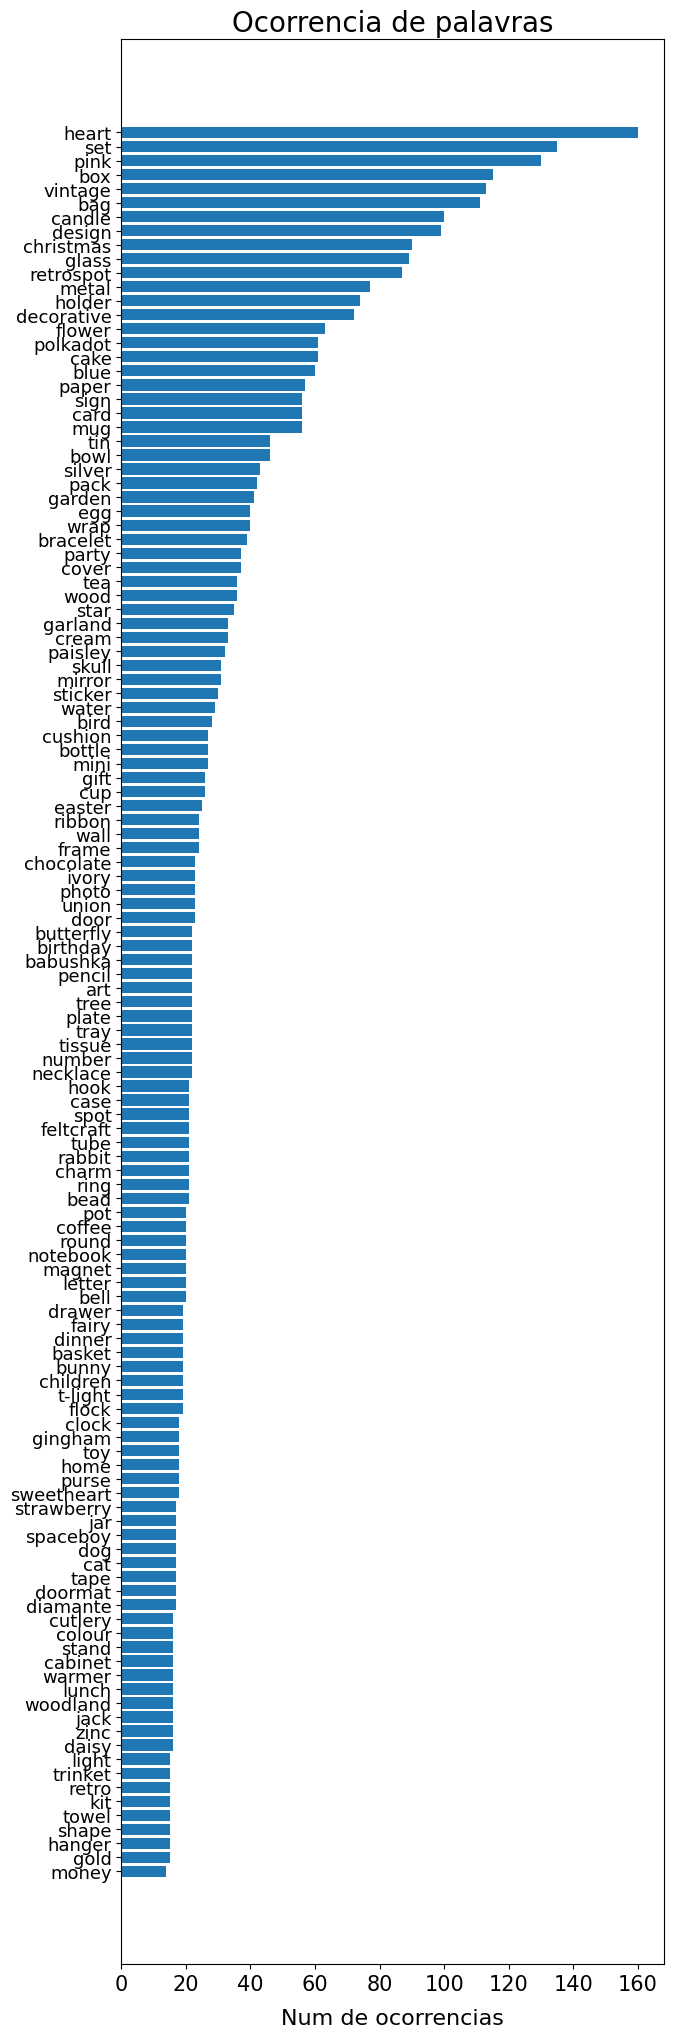

In [85]:
# Plotar o resultado

list = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list[:125]]
x_axis = [k for k,i in enumerate(list[:125])]
x_label = [i[0] for i in list[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Num de ocorrencias", fontsize = 16, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Ocorrencia de palavras",fontsize = 20)
plt.show()

- A separação dos resultados funcionou, consgui extrair a primeira palavra e o total de vezes que elas aparecem.
- São muitos os resultados que aparecem. Nesse caso tem algumas palavras que não ajudam na classificação (ex: cores) por isso posso remove-las.
- Além disso, quero trabalhar com palavras que apareceram mais de 20 vezes.

#### 4.2.2 Definir as categorias dos produtos

In [86]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue  #remover palavras desnecessárias
    if len(word) < 3 or v < 20: continue # trabalhar com palavras que apareceram mais de 20 vezes
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Palavras conservadas:', len(list_products))

Palavras conservadas: 82


#### 4.2.3 Codificar os dados

- Com base nos dados obtidos preciso realizar uma matriz X que indique as palavras na 'description' dos produtos utilizando on hot encoding.
- Além disso, considerando as faixas de compra posso adicionar 6 colunas a matriz indicando a faixa de preço dos produtos.

In [ ]:
list_of_products = per_product_df['description'].unique()
X = pd.DataFrame()
for product in list_of_products:
    X[product] = ecommerce_clean_27['description'].str.upper().str.contains(product.upper()).astype(int)

In [ ]:
# Criando as faixas de preço unitário

threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_of_products):
    prix = per_product_df[ per_product_df['description'] == prod]['unit_price'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [91]:
# Conferir a quantidade de valores por cada faixa de preço unitário

print("{:<8} {:<20} \n". format('faixa','num produtos'))

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}   {:<20}".format(col,X.loc[:, col].sum()))

faixa    num produtos         

0<.<1        566.0               
1<.<2        745.0               
2<.<3        509.0               
3<.<5        352.0               
5<.<10       285.0               
.>10         93.0                


- Conforme a distribuição, podemos ver que a maioria dos produtos (745) se encontra na faixa de valor unitario entre 1 e 2.

#### 4.2.4 Criar grupos de produtos

In [92]:
one = OneHotEncoder()

one.fit(X)

X = one.transform(X)

In [93]:
matrix = X.toarray()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.18008914701509315
For n_clusters = 4 The average silhouette_score is : 0.18627940751066457
For n_clusters = 5 The average silhouette_score is : 0.19220097153370988
For n_clusters = 6 The average silhouette_score is : 0.02713079879738164
For n_clusters = 7 The average silhouette_score is : 0.02930232479251647
For n_clusters = 8 The average silhouette_score is : 0.041225705722255125
For n_clusters = 9 The average silhouette_score is : 0.03612252306002949


- Nesse caso o n_clusters que apresentou melhor average silhouette score foi 5, portanto trabalharei com esse valor.
    - Obs: o Average silhouette score varia de -1 a 1 onde valores próximos a 1 significa que os pontos estão proximos uns aos outros, 0 que os clusters estão sobrepostos e -1 que estão agrupados de maneira incorreta.

In [95]:
# Trabalhando com n_clusters = 5
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.01793508370820823
For n_clusters = 5 The average silhouette_score is : 0.18802423732618043


#### 4.2.5 Caracterizando o conteudo dos grupos

In [96]:
pd.Series(clusters).value_counts()

0    35635
4      649
2      319
1      305
3      241
Name: count, dtype: int64

- Podemos ver que dentro dos 5 grupos, o grupo zero é o que apresenta o maior número de produtos.

### 4.2.6 Categorias de produtos

- Com base no agrupamento anterior e na criação dos cinco grupos agora preciso colocar o numero do agrupamento para cada produto.

In [115]:
# Atribuindo os valores dos grupos para cada produto
corresp = dict()
for key, val in zip (list_of_products, clusters):
    corresp[key] = val 
#__________________________________________________________________________
per_product_df['categ_product'] = per_product_df.loc[:, 'description'].map(corresp)

Na sequência posso criar colunas dizendo qual foi o total gasto em cada categoria de produto.

In [118]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = per_product_df[per_product_df['categ_product'] == i]
    price_temp = df_temp['unit_price'] * (df_temp['quantity'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    per_product_df.loc[:, col] = price_temp
    per_product_df[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
display(per_product_df[['invoice_no', 'description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5])

,invoice_no,description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
2,537626,SET/3 DECOUPAGE STACKING TINS,2,0.0,0.0,14.85,0.0,0.0
3,537626,ALARM CLOCK BAKELIKE CHOCOLATE,2,0.0,0.0,15.00,0.0,0.0
4,537626,ALARM CLOCK BAKELIKE GREEN,2,0.0,0.0,15.00,0.0,0.0
5,537626,ALARM CLOCK BAKELIKE RED,2,0.0,0.0,15.00,0.0,0.0
6,537626,ALARM CLOCK BAKELIKE PINK,2,0.0,0.0,15.00,0.0,0.0


- Com isso tenho separado por categoria qual foi o total gasto com determinado produto.
- Posso separar criando um dataframe para agrupar por pedido

In [147]:
count_categ_prod = per_product_df['categ_product'].value_counts()
print(count_categ_prod)

categ_product
0    20147
4    11024
2     5491
3      182
Name: count, dtype: int64


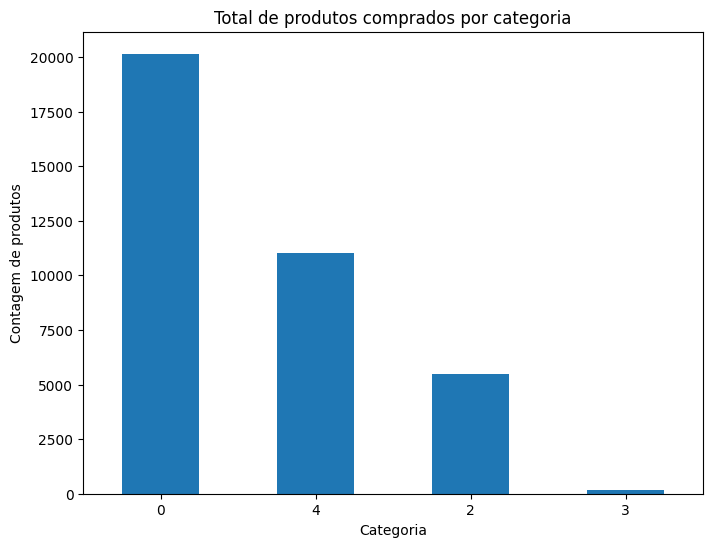

In [151]:
# Plotando a contagem de produtos por categoria

plt.figure(figsize=[8,6])
count_categ_prod.plot(kind='bar')
plt.ylabel('Contagem de produtos')
plt.xlabel('Categoria')
plt.xticks(rotation=0)
plt.title('Total de produtos comprados por categoria')
plt.show()

- Os dados nos mostram que a categoria zero é a que mais possui produtos (20147) vendidos.

In [119]:
# Criar tabela temporaria com os valores agregados
temp = per_product_df.groupby(by=['customer_id', 'invoice_no'], as_index=False)['total_spent'].sum()
basket_price = temp.rename(columns = {'total_spent':'basket_price'})

In [125]:
# Criar o ciclo for para iterar sobre cada um dos valores 
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = per_product_df.groupby(by=['customer_id', 'invoice_no'], as_index=False)[col].sum()
    basket_price[col] = temp[col]

In [126]:
# Criando coluna temporaria no dataframe para agrupar por valor gasto por categoria
per_product_df['InvoiceDate_int'] = per_product_df['invoice_date'].astype('int64')
temp = per_product_df.groupby(by=['customer_id', 'invoice_no'], as_index=False)['InvoiceDate_int'].mean()
per_product_df.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'invoice_date'] = pd.to_datetime(temp['InvoiceDate_int'])

In [127]:
# Imprimindo os resultados
basket_price = basket_price[basket_price['basket_price'] > 0]
basket_price.sort_values('customer_id', ascending = True)[:5]

,customer_id,invoice_no,basket_price,categ_0,invoice_date,categ_1,categ_2,categ_3,categ_4
0,12347,537626,650.89,255.8,2018-12-05 14:57:00,0.0,184.25,0.0,210.84
1,12347,556201,10.20,10.2,2019-06-07 13:01:00,0.0,0.00,0.0,0.00
2,12348,539318,292.80,279.6,2018-12-14 19:09:00,0.0,0.00,0.0,13.20
3,12356,541430,1565.58,815.7,2019-01-16 09:50:00,0.0,346.20,0.0,403.68
4,12357,574740,106.56,63.0,2019-11-04 16:07:00,0.0,20.16,0.0,23.40


- Nesse caso podemos ver então qual o id do usuário, qual o total do pedido que ele realizou e qual o total por categoria de produtos previamente separada.

Na sequência posso agrupar a contagem de compras feitas pelo usuario assim como os valores minimos, médios, maximos e total gasto durante todas as visitas.

In [129]:
# Calcular valores minimo, maximo, médio e total de compras realizadas pelos consumidores e anexar ao dataframe
transactions_per_user=basket_price.groupby(by=['customer_id'])['basket_price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['customer_id'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['customer_id'])['categ_0'].sum()
display(transactions_per_user.sort_values('customer_id', ascending = True)[:5])

,customer_id,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,2,10.20,650.89,330.545,661.09,40.236579,0.0,27.870638,0.000000,31.892783
1,12348,1,292.80,292.80,292.800,292.80,95.491803,0.0,0.000000,0.000000,4.508197
2,12356,1,1565.58,1565.58,1565.580,1565.58,52.102096,0.0,22.113210,0.000000,25.784693
3,12357,1,106.56,106.56,106.560,106.56,59.121622,0.0,18.918919,0.000000,21.959459
4,12359,1,547.50,547.50,547.500,547.50,29.369863,0.0,56.812785,2.712329,11.105023


- Funcionou a agregação dos novos valores.

Por fim posso adicionar o numero de dias entre a primeira compra e o número de dias desde a ultima compra

In [ ]:
# Obtendo o ultimo dia registrado
last_date = basket_price['invoice_date'].max().date()

# Obtendo as datas de registro e de última compra
first_registration = pd.DataFrame(basket_price.groupby(by=['customer_id'])['invoice_date'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['customer_id'])['invoice_date'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

# Adicionando os dados ao dataframe
transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['invoice_date']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['invoice_date']

display(transactions_per_user[:5])

In [135]:
transactions_per_user.describe()

,customer_id,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
count,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.0,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000
mean,15343.654762,2.046429,115.384881,217.528095,158.550471,318.579131,53.765879,0.0,15.819367,0.470416,29.944339,229.729167,285.975595
std,1726.899164,3.030162,192.682993,276.771830,201.786875,544.907179,31.956771,0.0,23.965802,3.323302,28.424161,132.743883,113.517794
min,12347.000000,1.000000,0.190000,0.190000,0.190000,0.190000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13870.750000,1.000000,5.040000,15.600000,14.040000,19.725000,36.690328,0.0,0.000000,0.000000,5.486544,99.750000,233.000000
50%,15368.000000,1.000000,19.800000,147.125000,104.212500,164.175000,56.793059,0.0,8.849954,0.000000,25.485130,277.000000,351.000000
75%,16873.500000,2.000000,166.605000,309.497500,234.821250,380.402500,73.674604,0.0,18.870006,0.000000,40.271817,357.000000,366.000000
max,18283.000000,57.000000,2140.110000,3164.100000,2140.110000,8185.390000,100.000000,0.0,100.000000,100.000000,100.000000,373.000000,373.000000


- Conclusão
    - Foi possível distribuir os produtos em 5 categorias onde, em média, os clientes gastam mais com a categoria 0 (53,76), seguido de produtos pertencentes a categoria 4 (29,94)
    - Na média geral, os consumidores gastam 158,55 em produtos, onde o valor mínimo médio é de 115,38 e o máximo é de 217,52 por carrinho.
    - Na separação das categorias nenhum produto entrou na categoria 1.

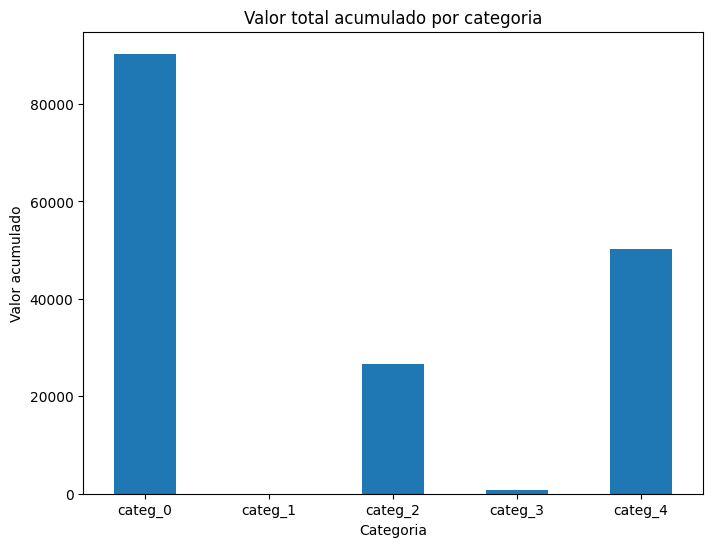

In [144]:
total_per_category = transactions_per_user[['categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']].sum()

plt.figure(figsize=[8,6])
total_per_category.plot(kind='bar')
plt.ylabel('Valor acumulado')
plt.xlabel('Categoria')
plt.xticks(rotation=0)
plt.title('Valor total acumulado por categoria')
plt.show()

In [145]:
print(total_per_category)

categ_0    90326.676115
categ_1        0.000000
categ_2    26576.536764
categ_3      790.298422
categ_4    50306.488699
dtype: float64


- O gráfico nos mostra que os produtos pertencentes a categoria 0 foram os que mais deram retorno financeiro para a empresa.

## 5 Conclusão

Análise de coorte:
- A análise de coorte dos gastos por usuário nos mostra que na maioria dos casos há um gasto maior no início, tendendo a redução com o passar do tempo a qual se mantém em um padrão de valores.
    - Ponto de ação: estudar as estratégias de marketing realizadas com o tempo buscando maior interação com o cliente para que ele continue comprando.

Com base na análise RFM:
- É importante realizar alguma medida a fim de não perder os clientes que estão em hibernação e prestes a hibernar.
    - É necessário realizar alguma atividade de marketing (envio de alguma promoção, contato com esses clientes) para estimular que eles voltem a comprar.
    - Outra alternativa seria realizar um estudo de mercado (pesquisa de satisfação talvez) para entender o que acontece por que temos muitos clientes em risco e em estado de hibernação ou prestes a hibernar.

Com base no agrupamento por produto:
- Produtos da categoria zero são os que mais trouxeram retorno para a empresa, e também são os produtos que mais foram vendidos.
    - Ponto de ação, é interessante manter esses produtos na linha pois são os que mais trazem retorno para a empresa.
- Produtos da categoria 3 foram os que menos trouxeram renda para a empresa (790,00), sendo estes também os produtos que menos foram comercializados (182 registros)
    - Ponto de ação: necessário estudar a viabilidade de se manter estes produtos em estoque, talvez compense zerar o que possivelmente exista no estoque e cancelar novas solicitações.

### Criar arquivos csv para usar no tableau

Para realizar a montagem dos dashboards no Tableau vou utilizar os DataFrames já formatados.

In [152]:
# O dataframe com os dados transformados
ecommerce_clean_27.to_csv('ecommerce_tableau.csv')

# O dataframe com os dados obtidos com RFM
rfm_table.to_csv('rfm_data.csv')

# O dataframe contendo os nomes dos produtos e as categorias que eles se enquadram
per_product_df.to_csv('categ_per_prod.csv')

# O dataframe mostrando o valor gasto por categoria e usuário
transactions_per_user.to_csv('transac_per_user.csv')

- Funcionou a extração.  